# Let an agent analyze your data
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

> This tutorial is advanced. You should have notions from [this other cookbook](agents) first!

In this notebook we will make a **data analyst agent: a Code agent armed with python library Pandas, that can load and transform dataframes, as well as plot the results!**

Let's say I want to solve the Titanic.

This agent will: ✅ Formulate the query itself and ✅ Critique to re-retrieve if needed. So it should naively recover some advanced RAG techniques!

Let's setup this system. 

Run the line below to install required dependancies:

In [1]:
!pip install seaborn "transformers[agents]"

We first create the agent. We used a `ReactCodeAgent` (read the [documentation](https://huggingface.co/docs/transformers/en/agents) to learn more about types of agents), so we do not even need to give it any tools: it can directly run its code.

We simply make sure to let it use data science-related libraries by passing these in `additional_authorized_imports`: `["numpy", "pandas", "matplotlib.pyplot", "seaborn"]`.

In general when passing libraries in `additional_authorized_imports`, make sure they are installed on your local environment, since the python interpreter can only use libraries installed on your environment.

In [1]:
from transformers.agents import HfEngine, ReactCodeAgent
from huggingface_hub import login
import os

login(os.getenv("HUGGINGFACEHUB_API_TOKEN"))

llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")

agent = ReactCodeAgent(
    tools=[],
    llm_engine=llm_engine,
    additional_authorized_imports=["numpy", "pandas", "matplotlib.pyplot", "seaborn"],
    max_iterations=10,
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/aymeric/.cache/huggingface/token
Login successful


======== New task ========
You are an expert data analyst.
Please load the source file and analyze its content.
According to the variables you have, begin by listing 3 interesting questions that could be asked on this data, for instance about specific correlations with survival rate.
Then answer these questions one by one, by finding the relevant numbers.
Meanwhile, plot some figures using matplotlib/seaborn and save them to the (already existing) folder './figures/': take care to clear each figure with plt.clf() before doing another plot.

In your final answer: summarize these correlations and trends
After each number derive real worlds insights, for instance: "Correlation between is_december and boredness is 1.3453, which suggest people are more bored in winter".
Your final answer should have at least 3 numbered and detailed parts.

You have been provided with these initial arguments: {'additional_notes': '\n### Variable Notes\npclass: A proxy for socio-economic status (SES)\n1st = U

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived

==== Agent is executing the code below:
# Calculate the correlation between age and survival rate
correlation = train_df['Age'].corr(train_df['Survived'])
print("Correlation between age and survival rate:", correlation)

# Plot the distribution of ages for survivors and non-survivors
plt.clf()
sns.kdeplot(train_df[train_df['Survived'] == 1]['Age'], label='Survivors')
sns.kdeplot(train_df[train_df['Survived'] == 0]['Age'], label='Non-Survivors')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Ages for Survivors and Non-Survivors')
plt.legend()
plt.savefig('./figures/age_distribution.png')
====
Print outputs:
Correlation between age and survival rate: -0.07722109457217756

==== Agent is executing the code below:
# Calculate the survival rate for each socio-economic class
survival_rates = train_df.groupby('Pclass')['Survived'].mean()
print("Survival rates for each socio-economic class:")
print(survival_rates)

# Plot the survival rates for each socio-economic class
plt.

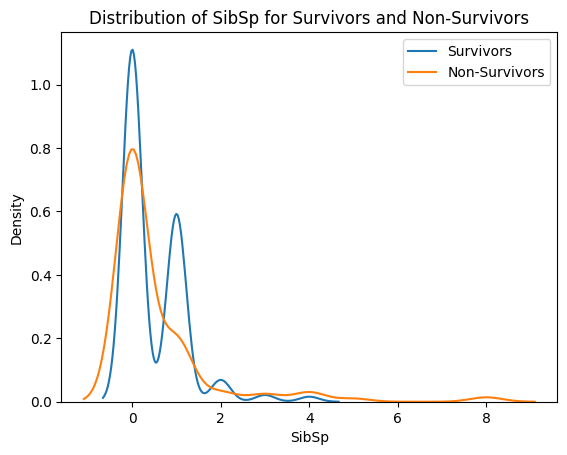

In [4]:
additional_notes = """
### Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)
parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.
"""

analysis = agent.run(
    """You are an expert data analyst.
Please load the source file and analyze its content.
According to the variables you have, begin by listing 3 interesting questions that could be asked on this data, for instance about specific correlations with survival rate.
Then answer these questions one by one, by finding the relevant numbers.
Meanwhile, plot some figures using matplotlib/seaborn and save them to the (already existing) folder './figures/': take care to clear each figure with plt.clf() before doing another plot.

In your final answer: summarize these correlations and trends
After each number derive real worlds insights, for instance: "Correlation between is_december and boredness is 1.3453, which suggest people are more bored in winter".
Your final answer should have at least 3 numbered and detailed parts.
""",
    additional_notes=additional_notes,
    source_file="titanic/train.csv",
)

In [5]:
print(analysis)

Based on the analysis, it seems that there is a weak negative correlation between age and survival rate, indicating that younger passengers were more likely to survive. Additionally, passengers in higher socio-economic classes had a higher survival rate, with the highest survival rate among those in class 1. Finally, there is a very weak negative correlation between the number of siblings/spouses on board and survival rate, suggesting that this factor had little impact on survival.


Impressive, isn't it? You could also arm the agent with a visualizer tool to let it reflect upon its own graphs!

But now let's go further and let the model run predictions on the data.

In [6]:
agent = ReactCodeAgent(
    tools=[],
    llm_engine=llm_engine,
    additional_authorized_imports=[
        "numpy",
        "pandas",
        "matplotlib.pyplot",
        "seaborn",
        "sklearn",
    ],
    max_iterations=12,
)

output = agent.run(
    """You are an expert machine learning engineer.
Please train a ML model on "titanic/train.csv" to predict the survival for rows of "titanic/test.csv".
Output the results under './output.csv'.
Take care to import functions and modules before using them!
""",
    additional_notes=additional_notes + "\n" + analysis,
)

======== New task ========
You are an expert machine learning engineer.
Please train a ML model on "titanic/train.csv" to predict the survival for rows of "titanic/test.csv".
Output the results under './output.csv'.
Take care to import functions and modules before using them!

You have been provided with these initial arguments: {'additional_notes': '\n### Variable Notes\npclass: A proxy for socio-economic status (SES)\n1st = Upper\n2nd = Middle\n3rd = Lower\nage: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5\nsibsp: The dataset defines family relations in this way...\nSibling = brother, sister, stepbrother, stepsister\nSpouse = husband, wife (mistresses and fiancés were ignored)\nparch: The dataset defines family relations in this way...\nParent = mother, father\nChild = daughter, son, stepdaughter, stepson\nSome children travelled only with a nanny, therefore parch=0 for them.\n\nBased on the analysis, it seems that there is a weak negative corr

The test predictions above, once submitted to Kaggle, score **0.78229**, which is #2824 out of 17,360, and better than what I had painfully achieved when trying the challenge a few years ago.

It seems that I've successfully managed to replace myself with an LLM, so I'm going to hand off my resignation.